# Bias correct CESM2 wind speeds to ERA5 using stress

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.file_io import find_processed_cesm2_file
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

# %load_ext line_profiler

In [5]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
cesm_dir = f'{base_dir}climate-forcing/CESM2/LE2/ensemble_mean/'
era5_dir = f'{base_dir}ERA5-forcing/climatology/'

mesh_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze().isel(nav_lev=0)

# CESM2_angle = xr.open_dataset(f'{cesm_dir}CESM2-LE2_eANT025_wind_angle_3-hourly_ensemble_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)
# CESM2_speed = xr.open_dataset(f'{cesm_dir}CESM2-LE2_eANT025_wind_speed_3-hourly_ensemble_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)

# ERA5_angle  = xr.open_dataset(f'{era5_dir}ERA5_eANT025_wind_angle_3-hourly_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)
# ERA5_speed  = xr.open_dataset(f'{era5_dir}ERA5_eANT025_wind_speed_3-hourly_1979-2024_mean_monthly.nc').where(mesh_mask.tmask!=0)

In [6]:
var='VBOT'
for year in range(1921, 1930):
    file_pathx = find_processed_cesm2_file('LE2', var, '1011.001', year, freq='3-hourly', highres=True)
    dsx = xr.open_dataset(file_pathx) 
    for month in range(1,13):
        print(f'y{year}m{month:02}')
        dsx_sub = dsx.isel(time_counter=(dsx.time_counter.dt.month==month))
        
        dsx_sub.to_netcdf(f'{cesm_dir}../CESM2-LE2_eANT2025_3-hourly_{var}_y{year}m{month:02}.nc')

In [7]:
bias_ds       = xr.open_dataset(f'{cesm_dir}bias_corr/CESM2-LE2_wind_speed_3-hourly_bias_corr_monthly.nc').wind_speed
bias_ds_angle = xr.open_dataset(f'{cesm_dir}bias_corr/CESM2-LE2_wind_angle_3-hourly_bias_corr.nc').wind_angle

In [8]:
out_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/new_bias-corrected/angle/'

In [ ]:
year = 1922
for month in range(1,13):
    print(month)
    dsx = xr.open_dataset(f'{cesm_dir}../CESM2-LE2_eANT2025_3-hourly_UBOT_y{year}m{month:02}.nc')
    dsy = xr.open_dataset(f'{cesm_dir}../CESM2-LE2_eANT2025_3-hourly_VBOT_y{year}m{month:02}.nc')

    theta   = np.arctan2(dsy.VBOT, dsx.UBOT)        
    speed   = np.hypot(dsx.UBOT, dsy.VBOT)
    
    theta_corrected = theta + bias_ds_angle # correct wind angle
    angle_u = np.cos(theta_corrected) * speed
    angle_v = np.sin(theta_corrected) * speed
    
    dsx['UBOT'] = angle_u * bias_ds.sel(month=month)
    dsy['VBOT'] = angle_v * bias_ds.sel(month=month)

    dsx.to_netcdf(f"{out_dir}CESM2-LE2_ens1011.001_eANT025_3-hourly_UBOT_bias_corr_monthly_2D_y{year}m{month:02}.nc", unlimited_dims=['time_counter'])
    dsy.to_netcdf(f"{out_dir}CESM2-LE2_ens1011.001_eANT025_3-hourly_VBOT_bias_corr_monthly_2D_y{year}m{month:02}.nc", unlimited_dims=['time_counter'])

1
2


In [14]:
def bias_correct(year):
    bias_ds_angle = xr.open_dataset(f'{cesm_dir}bias_corr/CESM2-LE2_wind_angle_3-hourly_bias_corr.nc').wind_angle
    file_pathx = find_processed_cesm2_file('LE2', 'UBOT', '1011.001', year, freq='3-hourly', highres=True)
    file_pathy = find_processed_cesm2_file('LE2', 'VBOT', '1011.001', year, freq='3-hourly', highres=True)

    dsx = xr.open_dataset(file_pathx)
    dsy = xr.open_dataset(file_pathy)
    
    for month in range(1,2):
        print(month)
        dsx_sub = dsx.isel(time_counter=(dsx.time_counter.dt.month==month))
        dsy_sub = dsy.isel(time_counter=(dsy.time_counter.dt.month==month))

        print('calculating')
        theta   = np.arctan2(dsy_sub.VBOT, dsx_sub.UBOT)
        speed   = np.hypot(dsx_sub.UBOT, dsy_sub.VBOT)
        theta_corrected = theta + bias_ds_angle # correct wind angle
        angle_u = np.cos(theta_corrected) * speed
        angle_v = np.sin(theta_corrected) * speed

        print('correcting')
        dsx_sub['UBOT'] = angle_u.apply(apply_multiplier)
        dsy_sub['VBOT'] = angle_v.apply(apply_multiplier)

    # months, dsxs = zip(*angle_u.groupby('time_counter.month')) #.apply(apply_multiplier)
    # months, dsys = angle_v.groupby('time_counter.month') #.apply(apply_multiplier)

    # out_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/new_bias-corrected/angle/'
    # print('saving')
    # years, datasets = zip(*ds.groupby("time.year"))
    # paths = [f"{y}.nc" for y in years]
    # xr.save_mfdataset(datasets, paths)
    # dsx.save_mfdataset()
    # dsx.to_netcdf(f"{out_dir}CESM2-LE2_ens1011.001_eANT025_3-hourly_UBOT_bias_corr_monthly_2D_y{year}.nc", unlimited_dims=['time_counter'])
    # dsy.to_netcdf(f"{out_dir}CESM2-LE2_ens1011.001_eANT025_3-hourly_VBOT_bias_corr_monthly_2D_y{year}.nc", unlimited_dims=['time_counter'])
    
    return dsx_sub

In [ ]:
ds = bias_correct(1921)

In [ ]:
%lprun -f bias_correct bias_correct(1921)

1


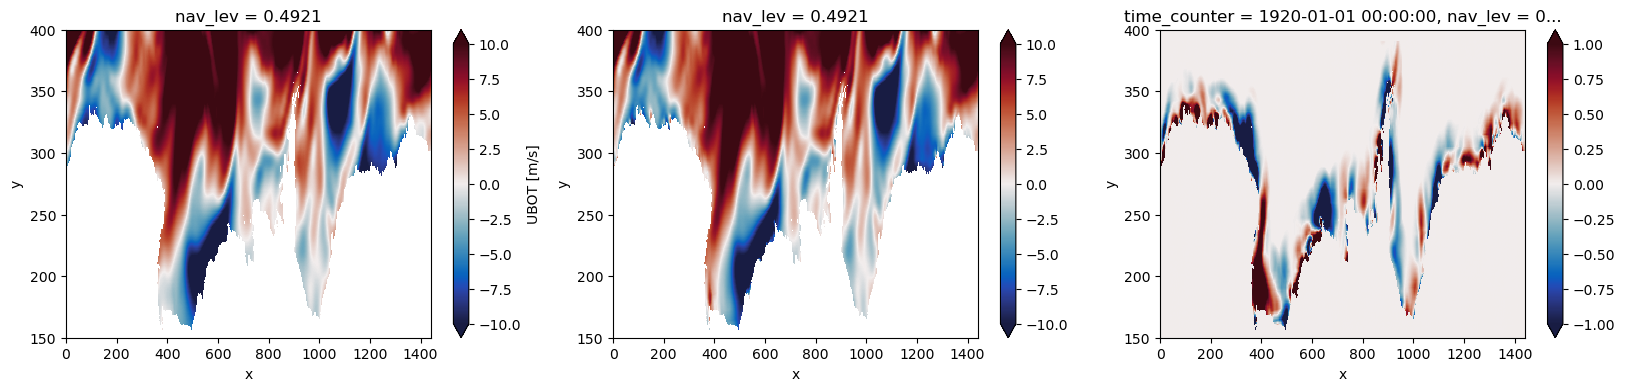

In [27]:
fig, ax =plt.subplots(1,3, figsize=(20,4))

dsx.UBOT.isel(time_counter=0).where(mesh_mask.tmask==1).plot(ax=ax[0], ylim=(150,400), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
angle_u.isel(time_counter=0).where(mesh_mask.tmask==1).plot(ax=ax[1], ylim=(150,400), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
(angle_u.isel(time_counter=0)- dsx.UBOT.isel(time_counter=0)).plot(ax=ax[2], vmin=-1, vmax=1, cmap=cmocean.cm.balance, ylim=(150,400))

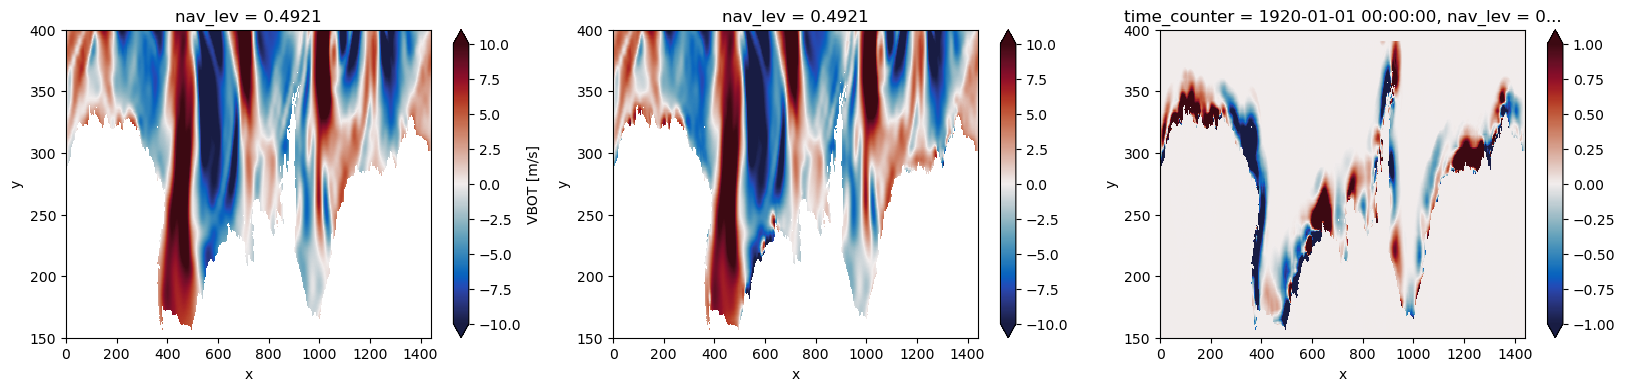

In [28]:
fig, ax =plt.subplots(1,3, figsize=(20,4))

dsy.VBOT.isel(time_counter=0).where(mesh_mask.tmask==1).plot(ax=ax[0], ylim=(150,400), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
angle_v.isel(time_counter=0).where(mesh_mask.tmask==1).plot(ax=ax[1], ylim=(150,400), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
(angle_v.isel(time_counter=0)- dsy.VBOT.isel(time_counter=0)).plot(ax=ax[2], vmin=-1, vmax=1, cmap=cmocean.cm.balance, ylim=(150,400))

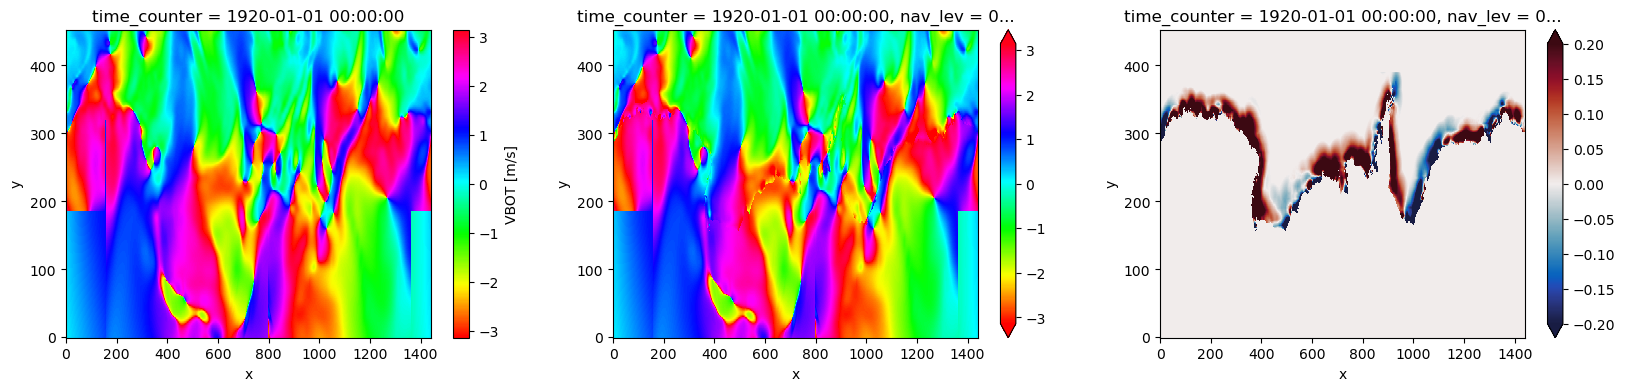

In [18]:
fig, ax =plt.subplots(1,3, figsize=(20,4))

theta.isel(time_counter=0).plot(ax=ax[0], vmin=-np.pi, vmax=np.pi, cmap='hsv')
theta_corrected.isel(time_counter=0).plot(ax=ax[1], vmin=-np.pi, vmax=np.pi, cmap='hsv')
(theta.isel(time_counter=0) - theta_corrected.isel(time_counter=0)).plot(ax=ax[2], vmin=-0.2, vmax=0.2, cmap=cmocean.cm.balance)

In [3]:
bias1 = xr.open_dataset(f'{cesm_dir}bias_corr/CESM2-LE2_wind_angle_3-hourly_bias_corr.nc')
bias2 = xr.open_dataset(f'{cesm_dir}bias_corr/CESM2-LE2_wind_angle_3-hourly_bias_corr_monthly.nc')

In [3]:
for pair in [(0, -1), (1, 0), (0, 1), (-1, 0)]:
    print(f'u: {pair[1]}, v: {pair[0]}, angle: {np.rad2deg(np.arctan2(pair[0], pair[1]))}')

u: -1, v: 0, angle: 180.0
u: 0, v: 1, angle: 90.0
u: 1, v: 0, angle: 0.0
u: 0, v: -1, angle: -90.0


In [4]:
CESM2_u = np.cos(CESM2_angle.wind_angle) * CESM2_speed.wind_speed
CESM2_v = np.sin(CESM2_angle.wind_angle) * CESM2_speed.wind_speed
ERA5_u  = np.cos(ERA5_angle.wind_angle) * ERA5_speed.wind_speed
ERA5_v  = np.sin(ERA5_angle.wind_angle) * ERA5_speed.wind_speed

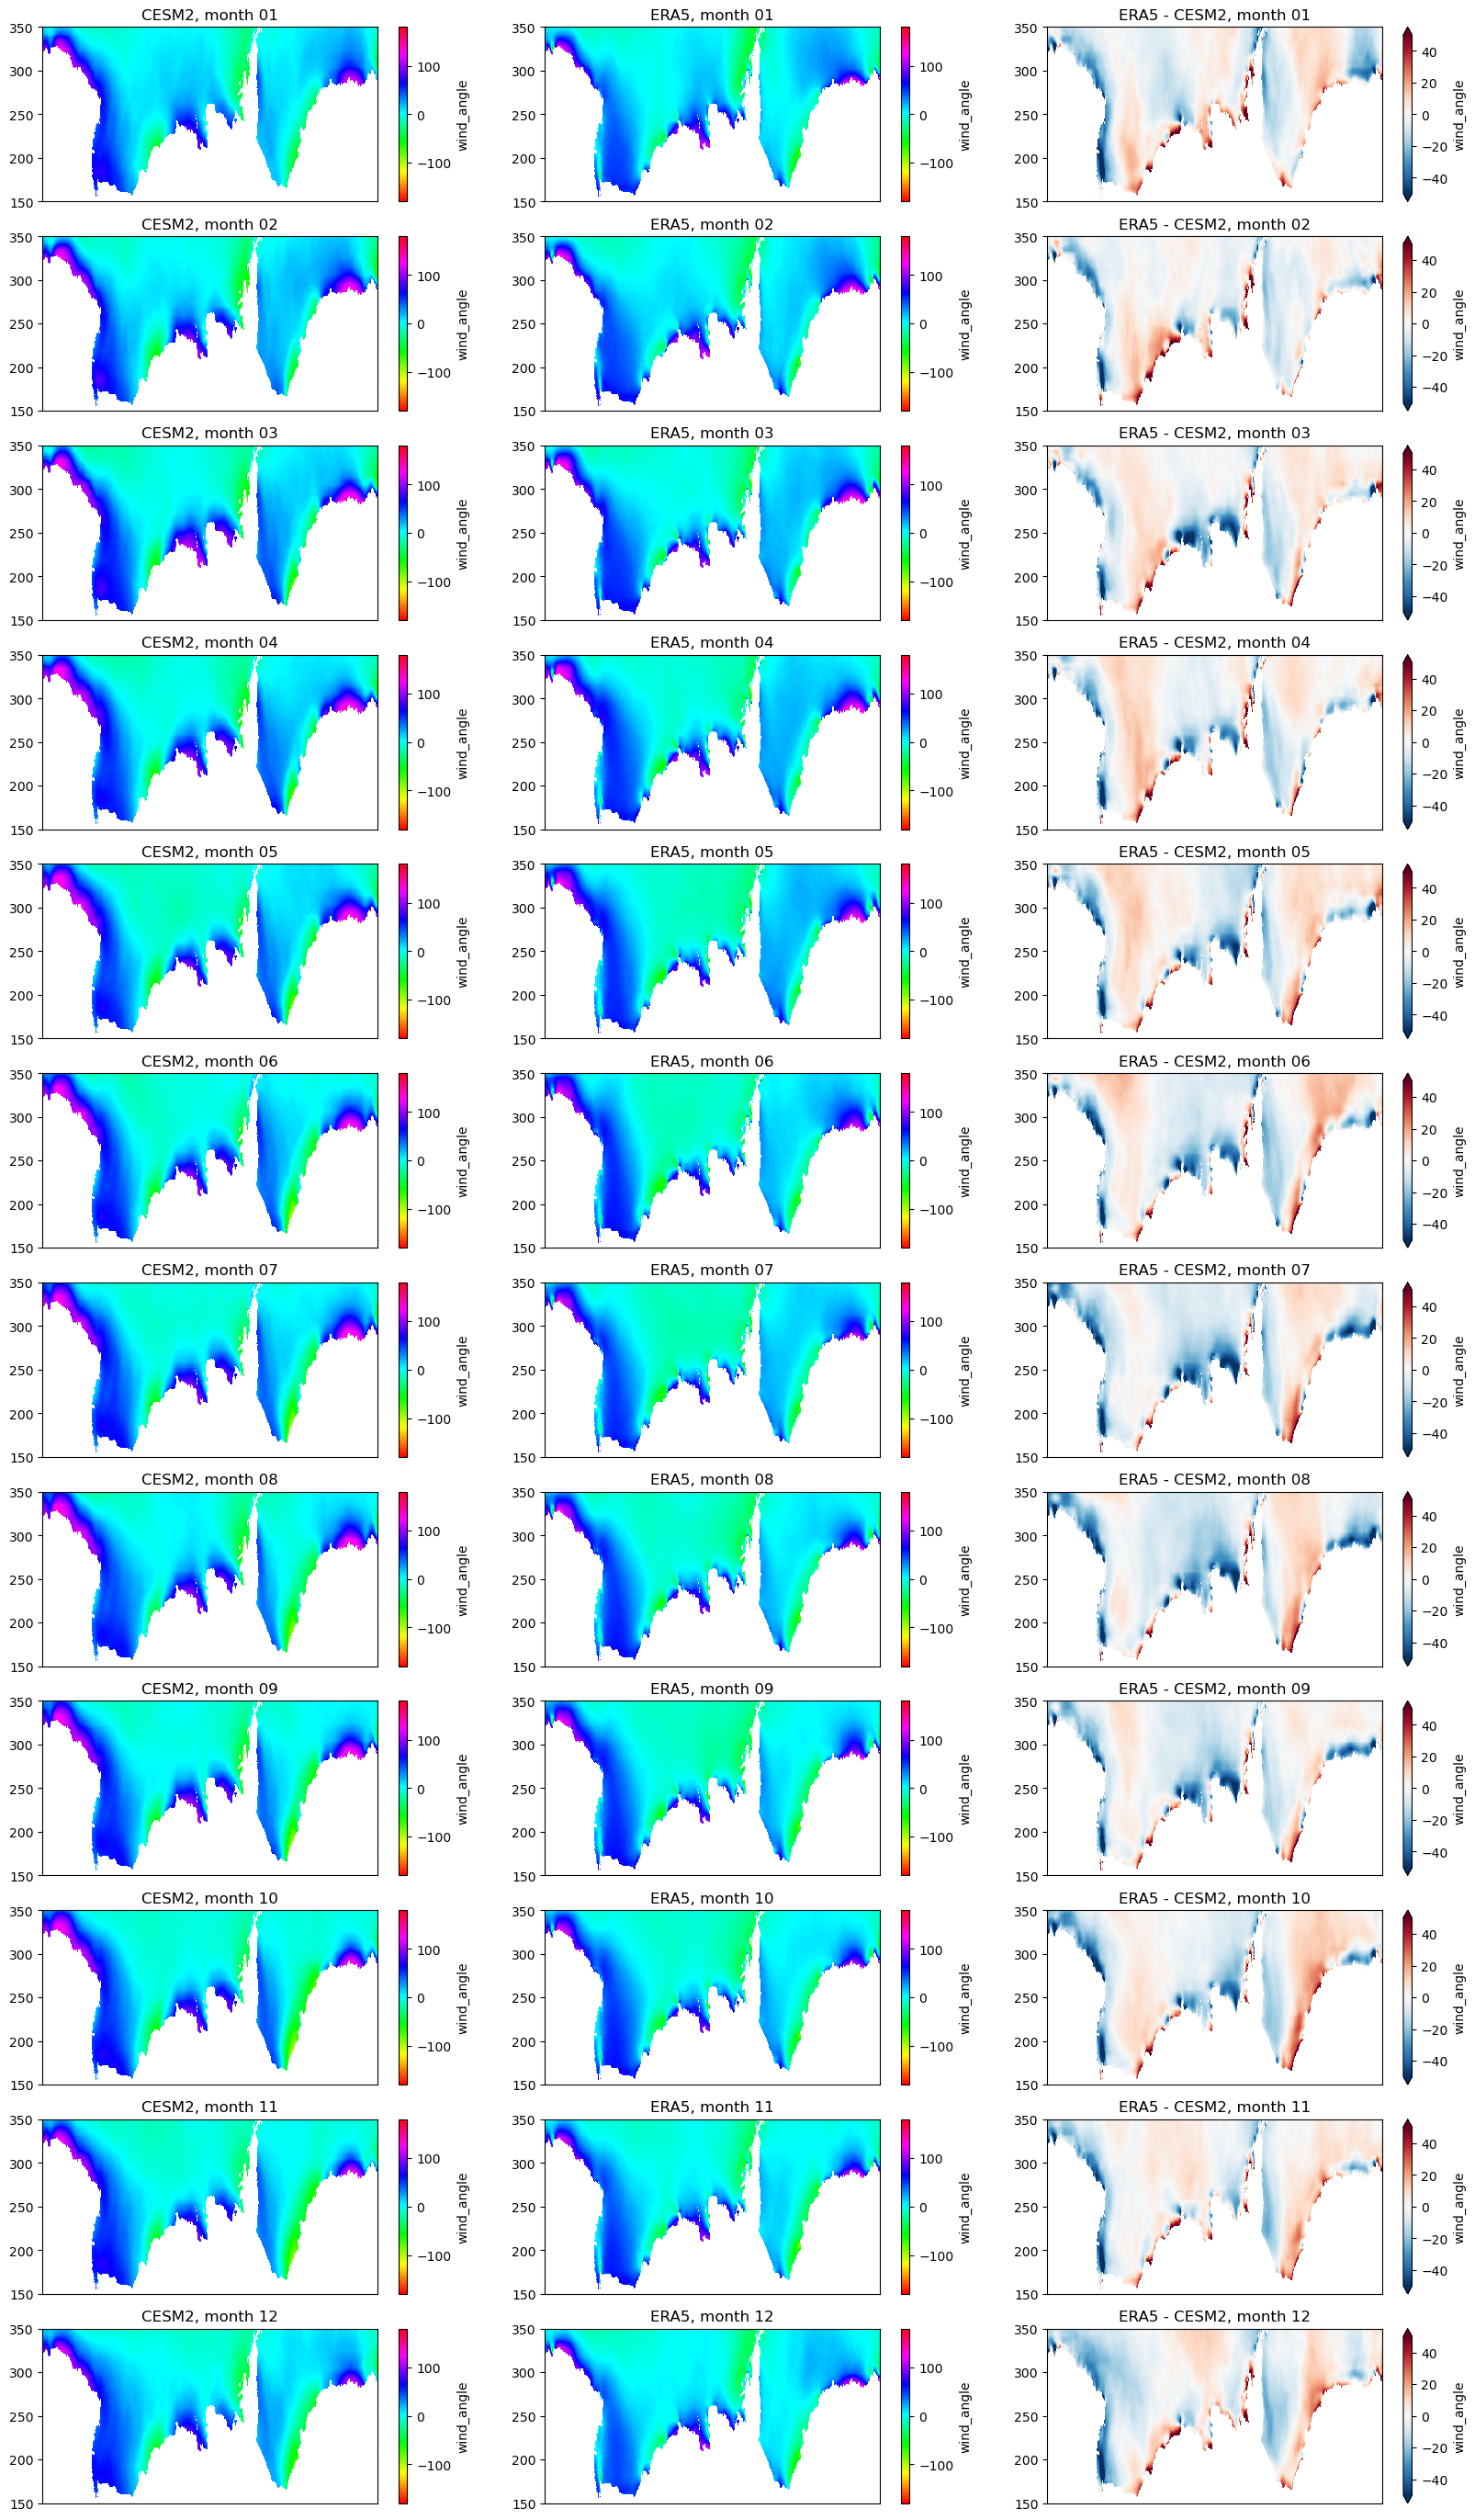

In [145]:
fig, ax = plt.subplots(12,3,figsize=(20,35))
subset  = {'lon':slice(0,None,6), 'lat':slice(0,None,1)}
subset2 = {'lon':slice(0,None,6), 'lat':slice(0,None,3)}

for m, month in enumerate(range(0,12)):
    np.rad2deg(CESM2_angle.wind_angle.isel(month=month)).plot(ax=ax[m,0], cmap='hsv', vmin=-180, vmax=180)
    np.rad2deg(ERA5_angle.wind_angle.isel(month=month)).plot(ax=ax[m,1], cmap='hsv', vmin=-180, vmax=180)
    np.rad2deg((ERA5_angle.wind_angle.isel(month=month) - CESM2_angle.wind_angle.isel(month=month))).plot(ax=ax[m,2], cmap='RdBu_r', vmin=-50, vmax=50)
    
    ax[m,0].set_title(f'CESM2, month {m+1:02}')
    ax[m,1].set_title(f'ERA5, month {m+1:02}')
    ax[m,2].set_title(f'ERA5 - CESM2, month {m+1:02}')
    
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    axis.set_xticks([])
    axis.set_xlim(200, 1300)
    axis.set_ylim(150, 350)

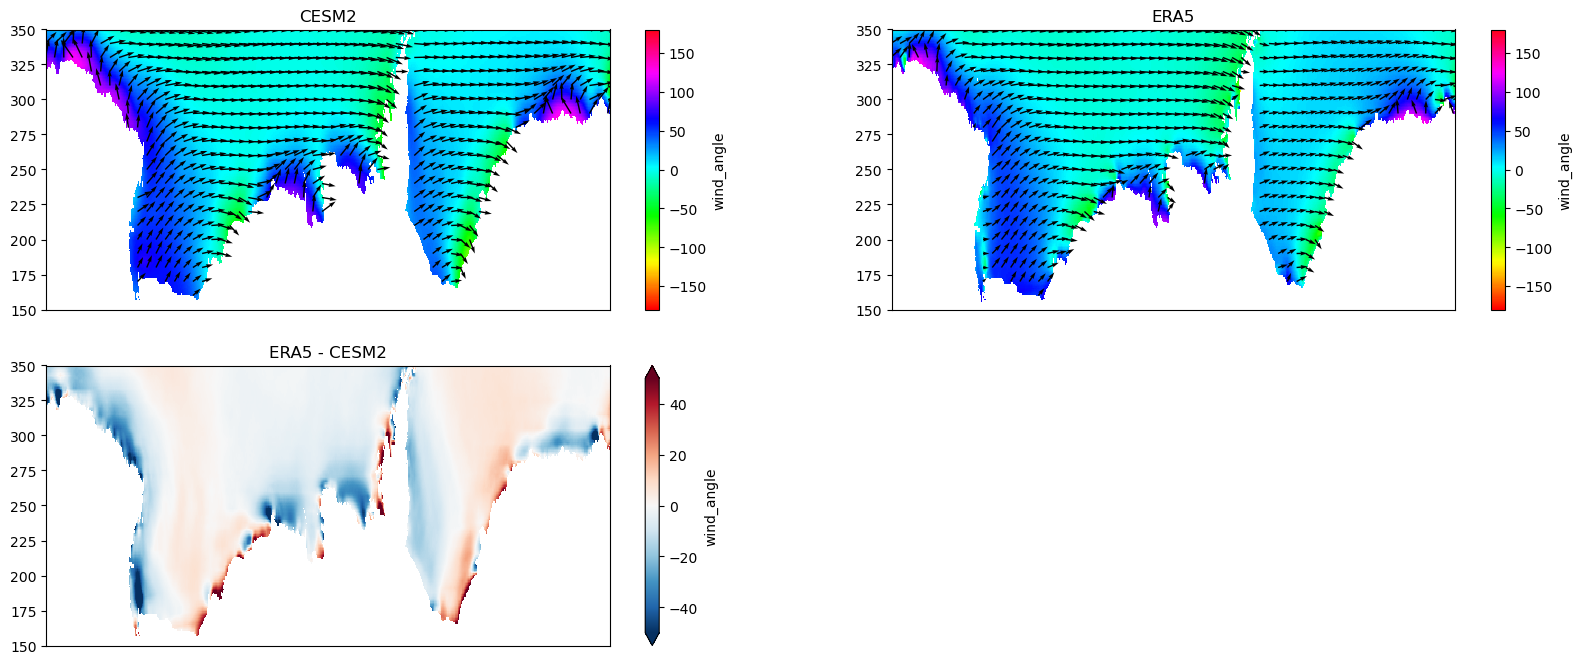

In [65]:
fig, ax = plt.subplots(2,2,figsize=(20,8))

np.rad2deg(CESM2_angle.wind_angle.mean(dim='month')).plot(ax=ax[0,0], cmap='hsv', vmin=-180, vmax=180)
np.rad2deg(ERA5_angle.wind_angle.mean(dim='month')).plot(ax=ax[0,1], cmap='hsv', vmin=-180, vmax=180)
np.rad2deg((ERA5_angle.wind_angle.mean(dim='month') - CESM2_angle.wind_angle.mean(dim='month'))).plot(ax=ax[1,0], cmap='RdBu_r', vmin=-50, vmax=50)

xind=18; yind=10;
ql = ax[0,0].quiver(CESM2_angle.x.values[::xind], CESM2_angle.y.values[::yind],
                    CESM2_u.mean(dim='month').values[::yind,::xind], CESM2_v.mean(dim='month').values[::yind,::xind],
                    width=2.5e-3, scale=310, color='k')
ql = ax[0,1].quiver(ERA5_angle.x.values[::xind], ERA5_angle.y.values[::yind],
                    ERA5_u.mean(dim='month').values[::yind,::xind], ERA5_v.mean(dim='month').values[::yind,::xind],
                    width=2.5e-3, scale=310, color='k')
ax[0,0].set_title('CESM2')
ax[0,1].set_title('ERA5')
ax[1,0].set_title('ERA5 - CESM2')
    
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    axis.set_xticks([])
    axis.set_xlim(200, 1300)
    axis.set_ylim(150, 350)
ax[1,1].remove()

### Coastal wind angle correction

In [30]:
from nemo_python_git.utils import distance_to_bdry, fix_lon_range

# get coastal mask
mesh_lon  = fix_lon_range(mesh_mask.nav_lon, max_lon=360)
distcoast = distance_to_bdry(mesh_lon, mesh_mask.nav_lat, (mesh_mask.tmask==0))
distcoast = xr.where(mesh_mask.tmask==0, 0, distcoast)
ds = distcoast.rename('distance_coast').to_dataset()
ds = ds.assign(nav_lon=mesh_mask.nav_lon, nav_lat=mesh_mask.nav_lat)
ds.to_netcdf(f'{base_dir}bathymetry/distance_coast-20250715.nc')

# # apply correction to distance within coastal_correction_limit (and excluding south america)
# coastal_correction_limit = 400 # km
# region_to_correct        = (distcoast < coastal_correction_limit)*(mesh_mask.nav_lat <-59)

# # find difference between wind angle for CESM2, ERA5
# angle_diff = ERA5_angle.wind_angle.mean(dim='month') - CESM2_angle.wind_angle.mean(dim='month')
# angle_diff = xr.where(region_to_correct, angle_diff, 0)

# # apply a cosine taper
# distance_scaled = xr.where(region_to_correct, np.cos((np.pi/2)*(distcoast/coastal_correction_limit)), 0)
# angle_diff_smoothed = angle_diff*distance_scaled

In [31]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:         (y: 453, x: 1440)
Coordinates:
    nav_lev         float32 4B 0.4921
    time_counter    float32 4B 0.0
Dimensions without coordinates: y, x
Data variables:
    distance_coast  (y, x) float32 3MB 0.0 0.0 0.0 0.0 ... 339.6 335.6 332.5
    nav_lon         (y, x) float32 3MB 73.0 73.25 73.5 ... 72.25 72.5 72.75
    nav_lat         (y, x) float32 3MB -89.5 -89.5 -89.5 ... -50.06 -50.06

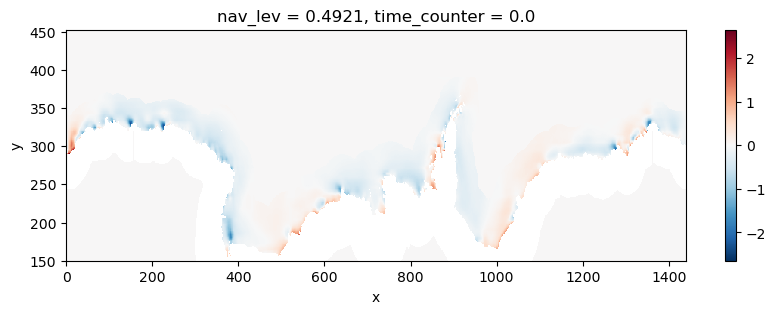

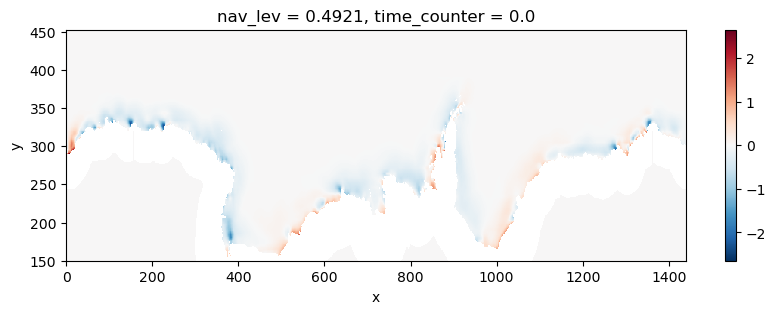

In [170]:
angle_diff.plot(figsize=(10,3), ylim=(150,None))
angle_diff_smoothed.plot(figsize=(10,3), ylim=(150,None))

In [171]:
CESM2_angle_corrected = CESM2_angle.wind_angle + angle_diff_smoothed
wind_u = np.cos(CESM2_angle_corrected) * CESM2_speed
wind_v = np.sin(CESM2_angle_corrected) * CESM2_speed

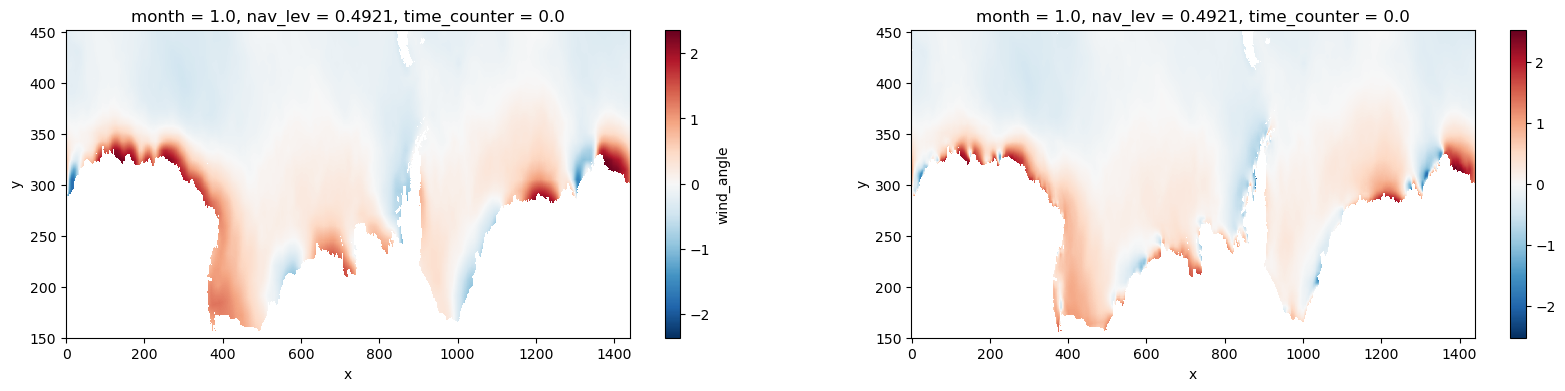

In [172]:
fig, ax = plt.subplots(1,2, figsize=(20,4))
CESM2_angle.wind_angle.isel(month=0).plot(ax=ax[0], ylim=(150,None))
CESM2_angle_corrected.isel(month=0).plot(ax=ax[1], ylim=(150,None))